### Model building and train / eval

In [1]:
import numpy as np
import pandas as pd


from implicit.als import AlternatingLeastSquares
from implicit.evaluation import AUC_at_k, mean_average_precision_at_k,ndcg_at_k,precision_at_k,ranking_metrics_at_k
from implicit.evaluation import train_test_split

import scipy.sparse as sparse



In [3]:
class QionghHaRecommender():
    __user_intl, __item_intl = 'user_internal', 'item_internal',
    __impl_intl = 'implicit_measure'
    
    def __init__(self, if_load_old = True):
        self.ALS_model = None
        if if_load_old:
            self.raw_data = pd.read_csv('steam_users_new.csv')
        self.lookup_items = None
        self.lookup_users = None
        self.data = None
    
    def create_model(self, factors = 20, regularization = 0.1,iterations = 20,alpha=1.5,random_state=42,show_loss=False):

        self.ALS_model = AlternatingLeastSquares(
                                        factors=factors,
                                        regularization=regularization,
                                        alpha =alpha,
                                        iterations=iterations,
                                        calculate_training_loss=show_loss,
                                        random_state=random_state)
        
        
    def load_data(self, data_path):
        
        df_data = pd.read_csv(data_path)
        
        self.raw_data = df_data.copy()
        
        col_user = df_data.columns[0]  # Name of column 'user'.
        col_item = df_data.columns[1]  # Name of column 'item'.
        col_impl = df_data.columns[6]  # Name of column 'implicit' measure.

        # Retrieve internal names for data columns.
        col_user_intl = self.__user_intl  # Internal name for 'user'.
        col_item_intl = self.__item_intl  # Internal name for 'item'.
        col_impl_intl = self.__impl_intl  # Internal name for 'implicit measure'.

        # Convert 'user' and 'item' into numerical ID.
        df_data[col_user_intl] = df_data[col_user].astype('category').cat.codes
        df_data[col_item_intl] = df_data[col_item].astype('category').cat.codes

        # Create lookup tables for 'user_id - user' and 'item_id - item'.
        lookup_user = df_data[[col_user_intl, col_user]].drop_duplicates()
        lookup_user[col_user_intl] = lookup_user[col_user_intl].astype(str)
        lookup_user[col_user] = lookup_user[col_user].astype(str)
        lookup_game = df_data[[col_item_intl, col_item]].drop_duplicates()
        lookup_game[col_item_intl] = lookup_game[col_item_intl].astype(str)


        df_data.rename(columns={col_impl: col_impl_intl}, inplace=True)
        df_data = df_data[[col_user_intl, col_item_intl, col_impl_intl]]

        self.data = df_data
        
        self.lookup_users = lookup_user

        self.lookup_items = lookup_game
        
        self.lookup_users.to_csv('lookup_users.csv',index=False)
        self.lookup_items.to_csv('lookup_items.csv',index=False)
        
        self.__user_o = col_user
        self.__item_o = col_item
        self.__impl_o = col_impl
        
    def train_model(self):

        if self.data is not None and self.ALS_model is not None:

            df_data = self.data
            data = df_data.implicit_measure.astype(float)
            row = df_data.user_internal
            
            col = df_data.item_internal
            # Create sparse matrices: item-user and user-item.
            sparse_user_item = sparse.csr_matrix((data.astype(float),(row,col)))

            # sparse_item_user = sparse.csr_matrix((data.astype(float),(col,row)))
                       
            # Initialize the als model and fit it using the sparse item-user matrix
            model = self.ALS_model

            # Fit data to the model
            model.fit(sparse_user_item)

            # Assign results to class variables.
            self.ALS_model = model
            self.sparse_user_item = sparse_user_item
        else:
            print('Erro: no data source or Model!')
    
    
    def eval(self,train_percentage=0.8,random_state=42,K=1,show_pro=False):
        
        train_ds, test_ds = train_test_split(self.sparse_user_item, train_percentage=train_percentage, random_state = random_state)
        userids = self.sparse_user_item.shape[0]
        
        model = self.ALS_model
        test_ids = np.arange(userids)
        
        p = precision_at_k(model, train_ds, test_ds[test_ids], K=K, show_progress=show_pro,num_threads=1)
        AUC = AUC_at_k(model, train_ds, test_ds[test_ids], K=K, show_progress=show_pro,num_threads=1)
        MAP = mean_average_precision_at_k(model, train_ds, test_ds[test_ids], K=K, show_progress=show_pro,num_threads=1)
        ndcg = ndcg_at_k(model, train_ds, test_ds[test_ids], K=K, show_progress=show_pro,num_threads=1)
        
        # print(f'P@K:{p}')
        # print(f'AUC_at_k:{AUC}')
        # print(f'MAP@K:{MAP}')
        # print(f'ndcg@K:{ndcg}')
        # print('finish one step')
        return p, AUC, MAP, ndcg


    def recommend_new_user(self, uid, game_list, hours, score, top_k):
        
        # new df
        new_df = pd.DataFrame({'user_id': [uid]*len(game_list),
                                'game_name': game_list,
                                'buy': [1]*len(game_list),
                                'play': [1]*len(game_list),
                                'hours': hours,
                                'score': score,
                                'implicit': [1]*len(game_list)})
        
        # save df as history
        new_df['implicit'] = new_df['buy'] + new_df['hours'].apply(lambda x: min((x-0.3),4)/10) + new_df['score'].apply(lambda x: (x-5)/20)
        new_df['implicit'] = new_df['implicit'].round(2)
            
        self.raw_data = self.raw_data.append(new_df, ignore_index=True)
        
        self.raw_data.to_csv('steam_users_new.csv', index=False)
        
        # get model
        if self.ALS_model is None:
           self.load_model()
        

        
        # read
        if self.lookup_users is None:
            lookup_users = pd.read_csv('lookup_users.csv',dtype={'user_internal': str})
        else:
            lookup_users = self.lookup_users
        if self.lookup_items is None:
            lookup_items = pd.read_csv('lookup_items.csv',dtype={'item_internal': str})
        else:
            lookup_items = self.lookup_items
            

        
        if len(lookup_users[lookup_users['user_id']==uid]) != 0:
            inter_uid = lookup_users[lookup_users['user_id']==uid]['user_internal'].astype(int).values[0]
        else:
            inter_uid = lookup_users['user_internal'].astype(int).max()+1
            inter_uid_df = pd.DataFrame({'user_internal':[f'{inter_uid}'],'user_id': [uid],})
            lookup_users = lookup_users.append(inter_uid_df, ignore_index=True)
            lookup_users.to_csv('lookup_users.csv',index=False)
        
        # create new sparse matrix
        int_item_list = []
        new_item_list = []
        int_value_list = []
        
        for game_id in range(len(game_list)):
            item_id = lookup_items[lookup_items['game_name']==game_list[game_id]]['item_internal'].astype(int)
            if len(item_id) != 0:
                int_item_list.append(item_id.values[0])
                int_value_list.append(new_df['implicit'][game_id])   
            else:
                new_item_id = lookup_items['item_internal'].astype(int).max() + 1
                new_item_list.append(new_item_id)
                int_item_list.append(new_item_id)
                int_value_list.append(new_df['implicit'][game_id])
                lookup_items = lookup_items.append(pd.DataFrame({'item_internal':[f'{new_item_id}' \
                    ],'game_name': [game_list[game_id]],}), ignore_index=True)
        
        max_row = len(lookup_users)
        max_col = len(lookup_items)
        
        # retrain model
        df_data = pd.DataFrame({
                self.__user_intl:[inter_uid]*len(int_item_list),
                self.__item_intl:int_item_list,
                self.__impl_intl:int_value_list
            })
        # drop df_data where df_data.item_internal not in new_item_list

        df_data_retrain_user = df_data[~df_data[self.__item_intl].isin(new_item_list)]
        # print(df_data_retrain_user)
        
        retrain = True
        if len(new_item_list)!= 0 or retrain:
            print('find new game, retrain model')
            self.load_data('steam_users_new.csv')
            self.create_model(factors = 40,regularization = 0.1,iterations = 20, alpha=5)
            self.train_model()
            # model.eval(K=10)
            lookup_users = self.lookup_users
            lookup_items = self.lookup_items 
            model = self.ALS_model
            inter_uid = lookup_users[lookup_users['user_id']==uid]['user_internal'].astype(int).values[0]
            ids, _ = model.recommend([inter_uid], self.sparse_user_item[inter_uid], N=top_k, filter_already_liked_items=True)
        
        else:
            print('no new game, update model')
            data = df_data_retrain_user.implicit_measure.astype(float)
            row = df_data_retrain_user.user_internal
            col = df_data_retrain_user.item_internal
            # Create sparse matrices: item-user and user-item.
            sparse_user_item = sparse.csr_matrix((data.astype(float),(row,col)),shape=(max_row,max_col-len(new_item_list)))
            model = self.ALS_model
            model.partial_fit_users([inter_uid],sparse_user_item[inter_uid])
            self.ALS_model = model
            
            ids, _ = model.recommend([inter_uid], sparse_user_item[inter_uid], N=top_k,filter_already_liked_items=True)
        
        
        rec_game_list = []
        for i in ids[0]:
            str_i = f'{i}'
            game_name = lookup_items[lookup_items['item_internal']==str_i]['game_name'].values[0]
            rec_game_list.append(game_name)
            
        # update model
        self.save_model()
        
        return rec_game_list
    
        
    def save_model(self):
        
        self.ALS_model.save('ALS_model.npz')
        print('save successfully!')
    
    
    def load_model(self,file_path = 'ALS_model.npz'):
        loaded_model = AlternatingLeastSquares(factors=50,regularization=0.01,alpha = 1.5,
                                                       iterations=10,calculate_training_loss=True,
                                                       random_state=42)
        self.ALS_model = loaded_model.load(file_path)
        
        print('load successfully!')
        
    def clean_df(self):
        self.raw_data = self.raw_data.drop_duplicates(subset=['user_id','game_name'], keep='last')
        self.raw_data.to_csv('steam_users_new.csv', index=False)
        
        
model = QionghHaRecommender(if_load_old = True)

# train & evaluate hisitory

# factors_list = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300] # regularization = 0.1,iterations = 20, alpha=1.5)
# ref_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8] # factors = 20,iterations = 20, alpha=1.5)
# iter_list = [1,2,3,4,5,6,7,8,9,10] # factors = 20,regularization = 0.1, alpha=1.5)
alph_list = [0.2,0.4,0.6,0.8,1] # factors = 20,regularization = 0.1,iterations = 20)
# k_list = [1,2,3,4,5,6,7,8,9,10]


result_dict = {'P@K':[], 'AUC_at_k':[], 'MAP@K':[], 'ndcg@K':[]}

for f in alph_list:
    print(f)
    model.load_data('steam_users_new.csv')
    model.create_model(factors = 120,regularization = 0.1,iterations = 5, alpha=f)
    # model.create_model(factors = 180,regularization = 0.1,iterations = 5, alpha=2)
    model.train_model()
    p, AUC, MAP, ndcg = model.eval(K=10)
    result_dict['P@K'].append(p)
    result_dict['AUC_at_k'].append(AUC)
    result_dict['MAP@K'].append(MAP)
    result_dict['ndcg@K'].append(ndcg)
    # model.save_model()


uid = 'new_legao6'
game_list = ['LEGO Batman 4']
hours = [50]
scores = [9]
top_k = 10
rec_list = model.recommend_new_user(uid, game_list, hours, scores, top_k)
model.clean_df()

rec_list

0.2


e:\Python\Anaconda3\lib\site-packages\implicit\utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/5 [00:00<?, ?it/s]

0.4


  0%|          | 0/5 [00:00<?, ?it/s]

0.6


  0%|          | 0/5 [00:00<?, ?it/s]

0.8


  0%|          | 0/5 [00:00<?, ?it/s]

1


  0%|          | 0/5 [00:00<?, ?it/s]

find new game, retrain model


  0%|          | 0/20 [00:00<?, ?it/s]

save successfully!


['Euro Truck Simulator 2',
 'F.E.A.R. 2 Project Origin',
 'Half-Life 2 Deathmatch',
 'Half-Life 2 Lost Coast',
 'F.E.A.R. 3',
 'Train Simulator',
 'Call of Duty Modern Warfare 3',
 'The Lord of the Rings War in the North',
 'BattleBlock Theater',
 'Scribblenauts Unlimited']

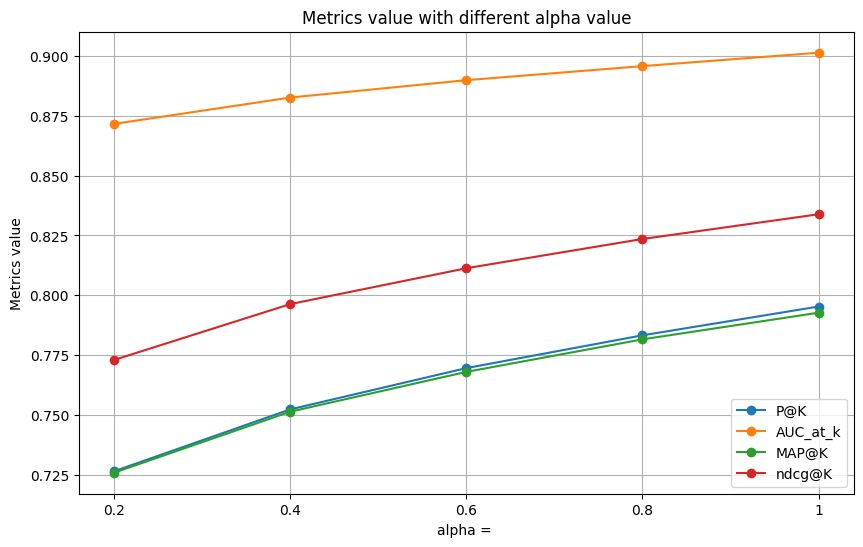

In [4]:
import matplotlib.pyplot as plt


parameters = alph_list 
for p in parameters:
    parameters[parameters.index(p)] = str(p)
indicators = ['P@K', 'AUC_at_k', 'MAP@K', 'ndcg@K']         #

data = result_dict

plt.figure(figsize=(10, 6))

for indid in indicators:
    y = data[indid]
    plt.plot(parameters, y, label=f'{indid}', marker='o')

plt.xlabel('alpha = ')
plt.ylabel('Metrics value')
plt.title('Metrics value with different alpha value')
plt.xticks(range(len(parameters)), parameters)
plt.legend(loc='best')
plt.grid(True)

plt.show()

In [5]:
# result_dict

In [6]:
#
# model.lookup_users.to_csv('lookup_users.csv',index=False)
# lookup_items = pd.read_csv('lookup_users.csv')
# lookup_items.info()

In [7]:
model.lookup_items

,item_internal,game_name
0,227,Alien Swarm
1,852,Cities Skylines
2,978,Counter-Strike
3,984,Counter-Strike Source
4,1131,Day of Defeat
...,...,...
127738,3026,Operation Z
128183,3507,Retaliation
128374,93,Abducted
128702,3849,SimpleRockets


In [8]:
# model.load_model()